In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os

In [3]:
ktm_data = pd.read_csv('../data/processed/Kathmandu_2025.csv')

In [4]:
# Convert the 'Date' column to datetime format
ktm_data['Date'] = pd.to_datetime(ktm_data['Date'], format='%Y-%m-%d')



In [24]:
# checking for missing values

print(ktm_data.isnull().sum() / len(ktm_data) * 100)

Date            0.000000
dew             0.000000
humidity        0.000000
pm1            44.035088
pm10            2.105263
pm25            0.526316
pressure        0.000000
temperature     0.000000
dtype: float64


In [334]:
year_2023.isnull().sum() / len(year_2023) * 100

Date             0.000000
dew             47.708895
humidity        22.641509
pm1             31.536388
pm10            30.997305
pm25            22.641509
pressure        22.641509
temperature     22.641509
wind-speed      22.641509
aqi_value       22.641509
aqi_category     0.000000
dtype: float64

### Computing the AQI Value using pm10 and pm2.5

### 🌈 AQI Interpretation Table (US EPA Standard)

| AQI Range     | Air Quality                      | Color     | Health Implications                                                                 |
|---------------|----------------------------------|-----------|--------------------------------------------------------------------------------------|
| 0 – 50        | **Good**                         | 🟢 Green  | Air quality is satisfactory. No risk to health.                                     |
| 51 – 100      | **Moderate**                     | 🟡 Yellow | Acceptable air quality. Some pollutants may affect very sensitive individuals.       |
| 101 – 150     | **Unhealthy for Sensitive Groups** | 🟠 Orange | Sensitive groups (children, elderly, people with respiratory issues) may be affected.|
| 151 – 200     | **Unhealthy**                    | 🔴 Red    | Everyone may begin to experience health effects.                                     |
| 201 – 300     | **Very Unhealthy**               | 🟣 Purple | Health alert: increased risk of serious effects for everyone.                        |
| 301 – 500     | **Hazardous**                    | 🟤 Maroon | Emergency conditions. Entire population is likely to be affected.                    |


In [6]:
# Corresponding AQI ranges
# (0, 50): Good
# (51, 100): Moderate
# (101, 150): Unhealthy for Sensitive Groups
# (151, 200): Unhealthy
# (201, 300): Very Unhealthy
# (301, 500): Hazardous
aqi_ranges = [
    (0, 50),
    (51, 100),
    (101, 150),
    (151, 200),
    (201, 300),
    (301, 500)
]                     

In [7]:
def compute_aqi(data):
    """
    Uses existing AQI values for PM2.5 and PM10, then combines them
    by taking the maximum for each day.
    
    Returns a dictionary with:
    - 'date': list of all dates in the original data
    - 'aqi_value': list of corresponding AQI values (max of PM2.5 and PM10 AQI)
    """
    dates = []
    aqi_values = []

    for i in range(len(data['Date'])):
        date = data['Date'].iloc[i]
        pm25_aqi = data['pm25'].iloc[i] if 'pm25' in data else np.nan
        pm10_aqi = data['pm10'].iloc[i] if 'pm10' in data else np.nan

        # Take the maximum of the two AQI values
        if not np.isnan(pm25_aqi) and not np.isnan(pm10_aqi):
            final_aqi = max(pm25_aqi, pm10_aqi)
        elif not np.isnan(pm25_aqi):
            final_aqi = pm25_aqi
        elif not np.isnan(pm10_aqi):
            final_aqi = pm10_aqi
        else:
            final_aqi = np.nan

        dates.append(date)
        aqi_values.append(final_aqi)

    return {
        'date': dates,
        'aqi_value': aqi_values
    }


In [8]:
def process_aqi_data(data):
    """
    Compute AQI for the given dataset and convert the 'date' column to datetime format.
    Returns a DataFrame with AQI values and formatted dates.
    """
    aqi_data = pd.DataFrame(compute_aqi(data))
    aqi_data['date'] = pd.to_datetime(aqi_data['date'], format='%Y-%m-%d')
    return aqi_data




In [9]:
# Process AQI data for all years
aqi_2024 = process_aqi_data(ktm_data)


In [10]:
print(
    "Missing values percentage in AQI 2022:\n", aqi_2024.isnull().sum() / len(aqi_2024) * 100, "\n"
)

Missing values percentage in AQI 2022:
 date         0.000000
aqi_value    0.526316
dtype: float64 



In [11]:
def merge_aqi_data(year_data, aqi_data):
    """
    Merge AQI data with the yearly data on the 'Date' column.
    Drops the redundant 'date' column after merging.
    """
    merged_data = pd.merge(year_data, aqi_data, left_on='Date', right_on='date', how='left')
    merged_data.drop(columns=['date'], inplace=True)
    return merged_data



In [12]:
# Apply the function to each year
year_2024 = merge_aqi_data(ktm_data, aqi_2024)



In [13]:
def add_aqi_category(data):
    """
    Add a new column to the dataset indicating the air quality level based on AQI ranges.
    """
    def get_aqi_category(aqi_value):
        if aqi_value is None or np.isnan(aqi_value):
            return "Unknown"
        for i, (low, high) in enumerate(aqi_ranges):
            if low <= aqi_value <= high:
                return ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"][i]
        return "Unknown"

    data['aqi_category'] = data['aqi_value'].apply(get_aqi_category)
    return data

In [14]:
year_2024 = add_aqi_category(year_2024)



In [20]:
def plot_aqi_category_distribution(dataframe, year, output_path='AQI_Categories_2024_Horizontal.png', loc='best', figsize=(12, 6)):
    """
    Plots a horizontal bar chart of AQI categories for a given year.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing at least 'aqi_category' column
    - year (int): Year of data (used in the title)
    - output_path (str): File path to save the plot
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.patches import Patch
    import pandas as pd

    # Copy data
    year_data = dataframe.copy()

    # Total records
    total_days = len(year_data)

    # AQI Categories full list (in order of severity: bottom to top)
    full_aqi_order = ['Good', 'Moderate', 
                      'Unhealthy for Sensitive Groups', 
                      'Unhealthy', 'Very Unhealthy', 'Hazardous']

    # Reverse order for bottom-to-top plotting
    aqi_order = full_aqi_order[::-1]

    # Custom AQI color palette
    custom_palette = {
        'Good': '#00e400',
        'Moderate': '#ffff00',
        'Unhealthy for Sensitive Groups': '#ff7e00',
        'Unhealthy': '#ff0000',
        'Very Unhealthy': '#8f3f97',
        'Hazardous': '#7e0023'
    }

    # AQI Ranges for legend
    aqi_ranges = {
        'Good': '0–50',
        'Moderate': '51–100',
        'Unhealthy for Sensitive Groups': '101–150',
        'Unhealthy': '151–200',
        'Very Unhealthy': '201–300',
        'Hazardous': '301–500'
    }

    # Count only present categories
    present_counts = year_data['aqi_category'].value_counts()
    present_categories = [cat for cat in aqi_order if cat in present_counts.index]

    # Filter data to only present categories
    year_data = year_data[year_data['aqi_category'].isin(present_categories)]

    # Set figure
    plt.figure(figsize=figsize)
    ax = sns.countplot(data=year_data, y='aqi_category', 
                       order=present_categories,
                       palette={k: custom_palette.get(k, 'gray') for k in present_categories},
                       dodge=False,
                          hue='aqi_category',
                          hue_order=present_categories
                       )

    # Title and labels
    plt.title(f'Distribution of Air Quality Index (AQI) Categories in {year}', 
              fontsize=16, weight='bold')
    plt.xlabel('Number of Days', fontsize=12)
    plt.ylabel('Air Quality Category', fontsize=12)

    # Custom axis styling
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.6, color='gray')
    ax.yaxis.grid(False)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_color('gray')
    ax.spines['bottom'].set_linewidth(0.8)

    # Annotate bars
    for p in ax.patches:
        width = p.get_width()
        label = f'{int(width)} Days\n({width / total_days * 100:.1f}%)'
        ax.annotate(label, (width + 1, p.get_y() + p.get_height() / 2), 
                    ha='left', va='center', fontsize=10, color='black')

    # Highlight most frequent category
    max_count = present_counts.max()
    for p in ax.patches:
        if p.get_width() == max_count:
            p.set_edgecolor('black')
            p.set_linewidth(2)

    # Custom legend with only present categories
    legend_elements = [
        Patch(facecolor=custom_palette[cat], edgecolor='black', 
              label=f"{cat} ({aqi_ranges[cat]})")
        for cat in present_categories
    ]

    plt.legend(handles=legend_elements, loc=loc, frameon=True, fontsize=9, title='AQI Categories (AQI Range)')

    # Add Total Days as annotation in top-left
    plt.gcf().text(0.01, 0.97, f'Total Days Recorded: {total_days}', fontsize=12, weight='bold', color='black')

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


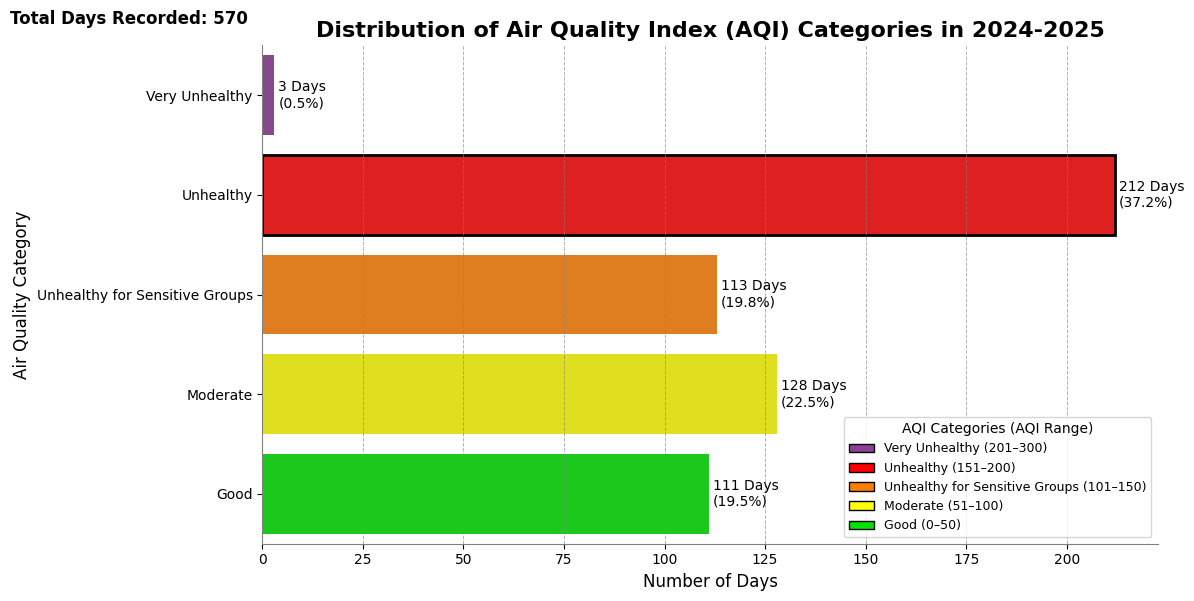

In [23]:
# Plotting the AQI category distribution for 2024
plot_aqi_category_distribution(year_2024, year='2024-2025', output_path='../results/images/AQI_Categories_2024_Horizontal.png')

In [25]:
year_2024.head()

,Date,dew,humidity,pm1,pm10,pm25,pressure,temperature,aqi_value,aqi_category
0,2024-01-01,7.5,87.0,113.0,61.0,138.0,1020.0,9.5,138.0,Unhealthy for Sensitive Groups
1,2024-01-02,6.5,81.5,95.0,63.0,116.0,1020.0,10.0,116.0,Unhealthy for Sensitive Groups
2,2024-01-03,6.0,81.5,109.0,59.0,131.0,1020.0,9.5,131.0,Unhealthy for Sensitive Groups
3,2024-01-04,5.0,78.0,103.0,66.0,140.0,1020.0,8.8,140.0,Unhealthy for Sensitive Groups
4,2024-01-05,4.0,76.0,131.0,62.0,140.0,1020.0,9.5,140.0,Unhealthy for Sensitive Groups


In [26]:
print(year_2024.isnull().sum() / len(year_2024) * 100)


Date             0.000000
dew              0.000000
humidity         0.000000
pm1             44.035088
pm10             2.105263
pm25             0.526316
pressure         0.000000
temperature      0.000000
aqi_value        0.526316
aqi_category     0.000000
dtype: float64


In [27]:
year_2024.columns

Index(['Date', 'dew', 'humidity', 'pm1', 'pm10', 'pm25', 'pressure',
       'temperature', 'aqi_value', 'aqi_category'],
      dtype='object')

In [28]:
final_data = year_2024.drop(columns=['dew', 'humidity', 'pm1', 'pm10', 'pm25', 'pressure','temperature'], axis=1)

In [29]:
print(final_data.isnull().sum() / len(final_data) * 100)


Date            0.000000
aqi_value       0.526316
aqi_category    0.000000
dtype: float64


In [30]:
final_data.to_csv('../data/processed/ktm_clean.csv', index=False)